In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
!pip install -q findspark

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" #"/usr/lib/jvm/java-11-openjdk-amd64" #
os.environ["SPARK_HOME"] = "spark-3.2.0-bin-hadoop3.2"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


################ The Recommendation Engine #####################

In [ ]:
%config IPCompleter.greedy=True

findspark.init()

from pyspark import SparkConf
from pyspark import SparkContext
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark.mllib.recommendation import ALS
from pyspark.mllib.recommendation import Rating

In [ ]:
conf = SparkConf().set("spark.ui.port", "4050") \
                  .setAppName('Anime and chill recommendation system') \
                  .setMaster('local')
sc = SparkContext(conf=conf)
#SparkContext.getOrCreate(conf=conf)
spark = SparkSession.builder \
    .config(conf=conf) \
    .getOrCreate()

We get 3  the ratings from our preprocessed data folder

In [ ]:
rating = sc.textFile("/content/drive/MyDrive/animeandchill/preprocessed_data/rating.csv")
header = rating.first() #extract header
rating = rating.filter(lambda row: row != header)   #filter out header
rating.take(3)

['2485327,59,6', '2485327,74,7', '2485327,120,8']

## Training

Splitting the rating dataset into test and train dataset


In [ ]:
trainingRatings, testRatings = rating.randomSplit([0.7, 0.3])

### 1. Split each line by comma to separate user IDs, item IDs, and ratings

In [ ]:
trainingData = trainingRatings.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
trainingData.take(3)

[Rating(user=2485327, product=59, rating=6.0),
 Rating(user=2485327, product=74, rating=7.0),
 Rating(user=2485327, product=120, rating=8.0)]

In [ ]:
testData = testRatings.map(lambda l: l.split(',')).map(lambda l: (int(l[0]), int(l[1])))
testData.take(3)

[(2485327, 232), (2485327, 857), (2485327, 1698)]

The function calc_mse computes the Mean Squared Error (MSE),to evaluate the accuracy of prediction model.

In [ ]:
def calc_mse(test_rating, predict_rating):
    sum=0
    n=len(predict_rating)
    for i in range(0,n):
        difference = test_rating[i]-predict_rating[i]
        squared_difference = difference**2
        sum = sum +squared_difference
    MSE =sum/n
    print("The Mean Square Error is: ", MSE)

Plot function

In [ ]:
def plot_performance_evaluation_of_model(test_ratings, predict_ratings):
    bars1 = test_ratings[0:5]
    bars2 = predict_ratings[0:5]

    barWidth = 0.3

    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]

    plt.figure(figsize=(20,16))
    plt.bar(r1, bars1, width = barWidth, color = 'indigo', edgecolor = 'black', capsize=8, label='Rating')
    plt.bar(r2, bars2, width = barWidth, color = 'teal', edgecolor = 'black', capsize=8, label='Prediction')

    plt.xticks([r + barWidth for r in range(len(bars1))], ['Prediction_1', 'Prediction_2', 'Prediction_3', 'Prediction_4', 'Prediction_5'])
    plt.ylabel('Rating')
    plt.legend()

    plt.show()

## ALS- Alternating Least Square

The Mean Square Error is:  4.690853248173817


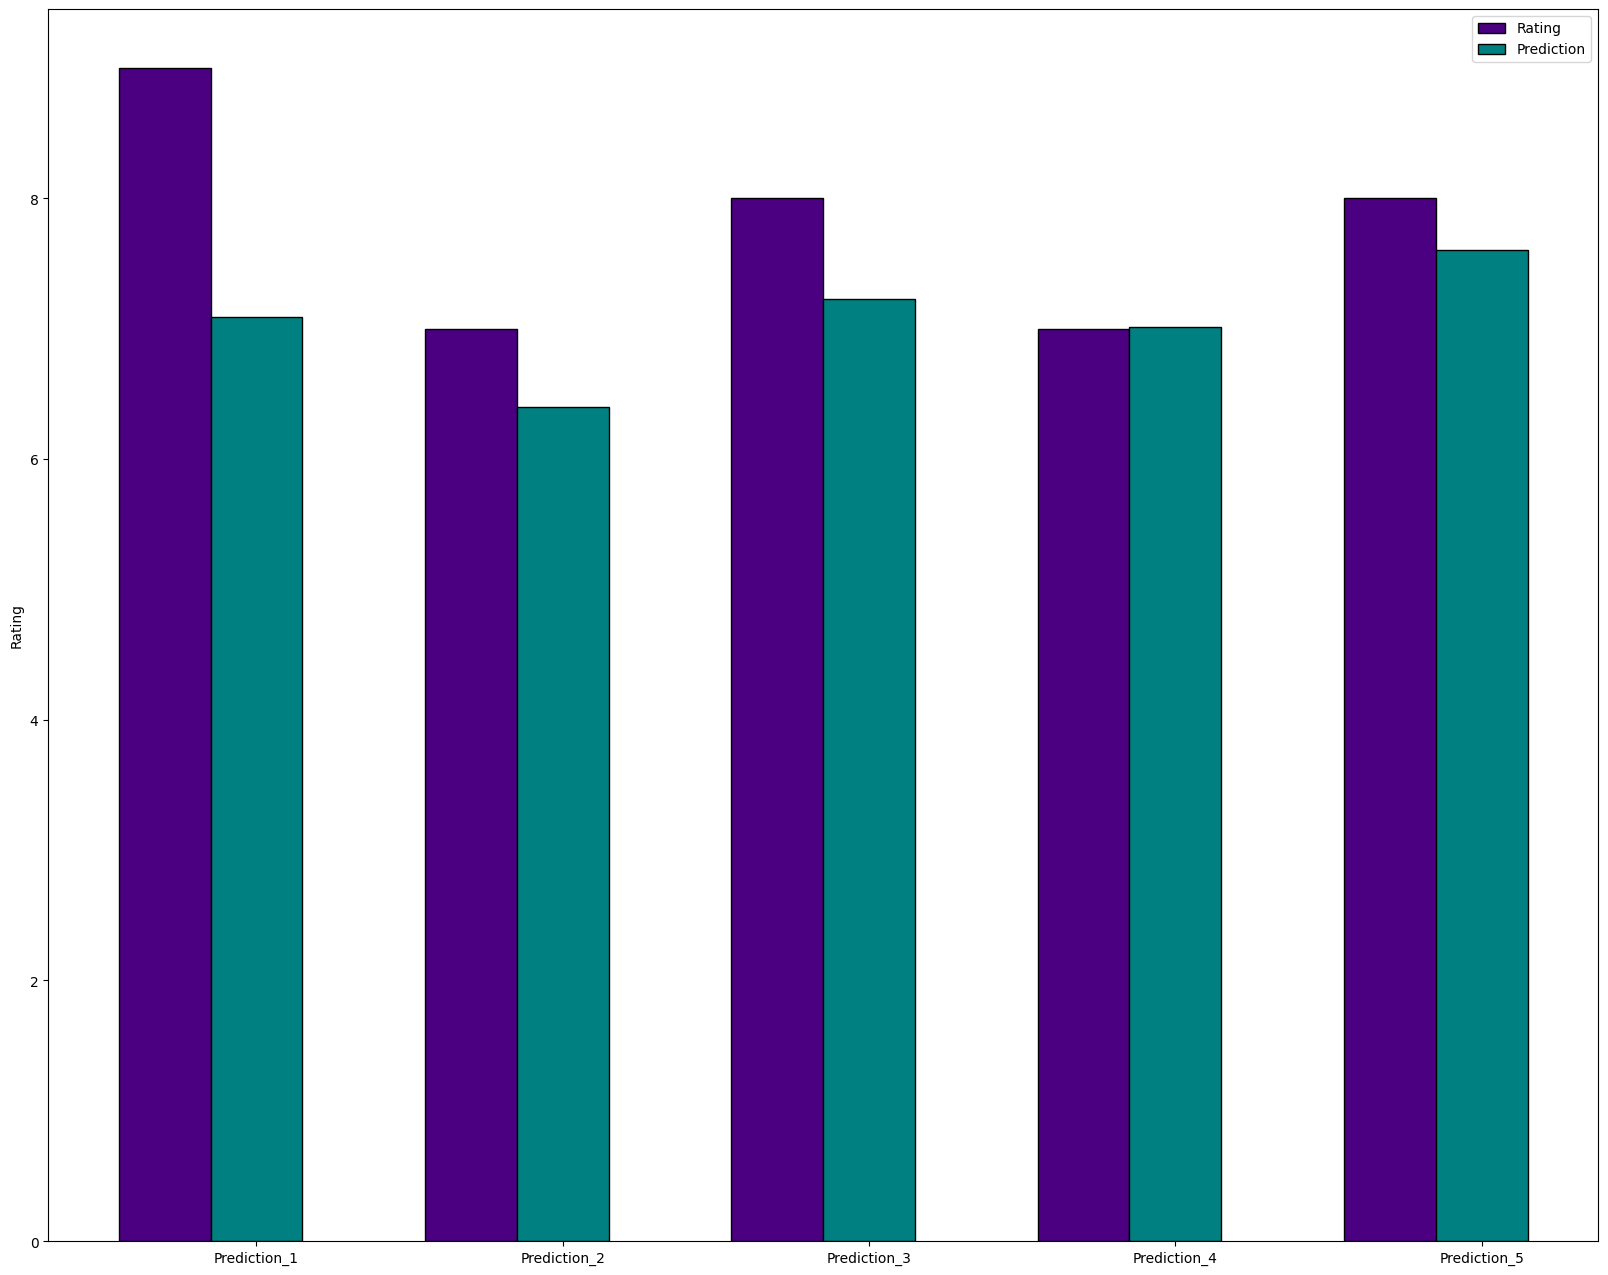

In [ ]:
# Als model parameters
rank, iter, lambda_ = 10, 15, 0.2
model = ALS.train(trainingData, rank=rank, iterations=iter, lambda_=lambda_, seed=2506) #myluckynumber

#Prediction
predictions = model.predictAll(testData)
allPredictRatings=predictions.map(lambda l: float(l[2]))

# Comparision of actual ratinge
arr_allPredictRatings=allPredictRatings.collect()
allTestRatings = testRatings.map(lambda l: l.split(',')).map(lambda l: (float(l[2])))
arr_allTestRatings=allTestRatings.collect()

# Calculate MSE
calc_mse(arr_allTestRatings, arr_allPredictRatings)
plot_performance_evaluation_of_model(arr_allTestRatings, arr_allPredictRatings)

The Mean Square Error is:  5.212132090820498


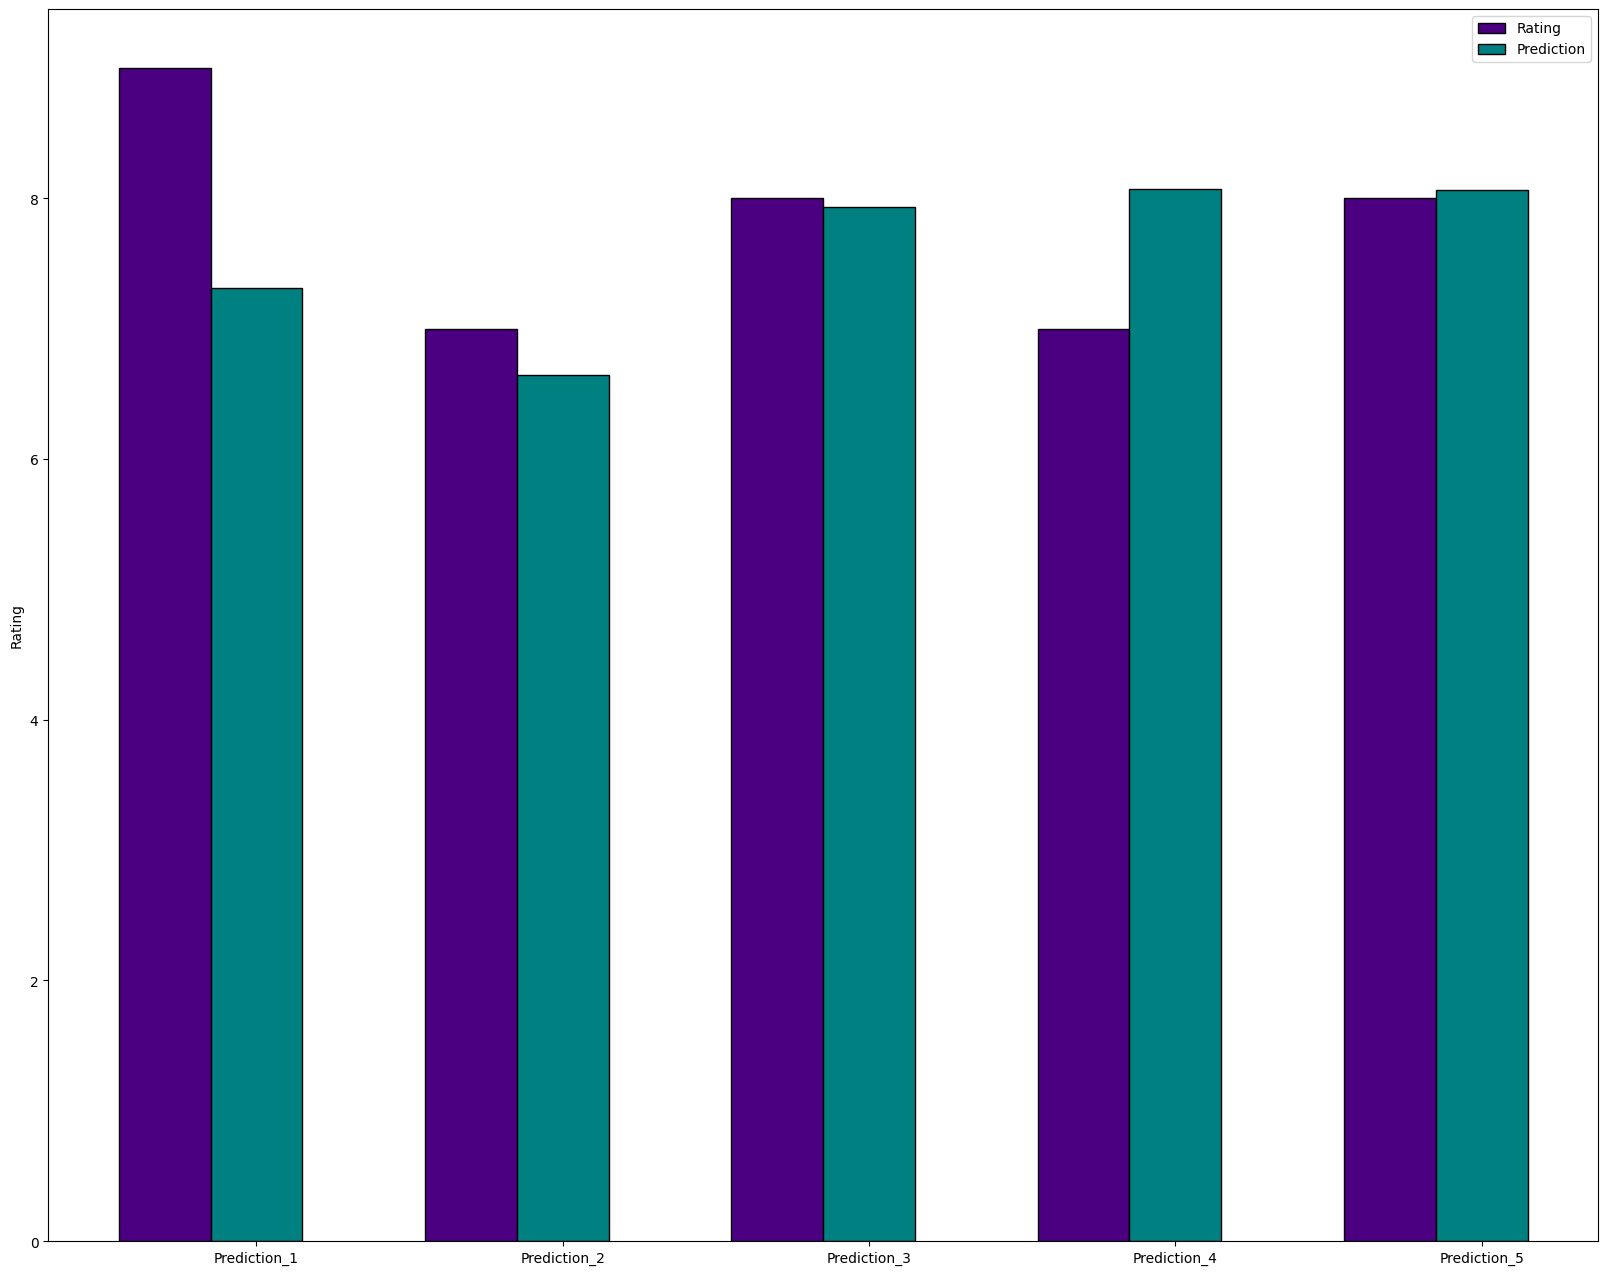

In [ ]:
rank, iter, lambda_ = 10, 15, 0.01
model = ALS.train(trainingData, rank=rank, iterations=iter, lambda_=lambda_, seed=2506)

predictions = model.predictAll(testData)
allPredictRatings=predictions.map(lambda l: float(l[2]))

arr_allPredictRatings=allPredictRatings.collect()
allTestRatings = testRatings.map(lambda l: l.split(',')).map(lambda l: (float(l[2])))
arr_allTestRatings=allTestRatings.collect()

calc_mse(arr_allTestRatings, arr_allPredictRatings)
plot_performance_evaluation_of_model(arr_allTestRatings, arr_allPredictRatings)

The Mean Square Error is:  4.832429331673415


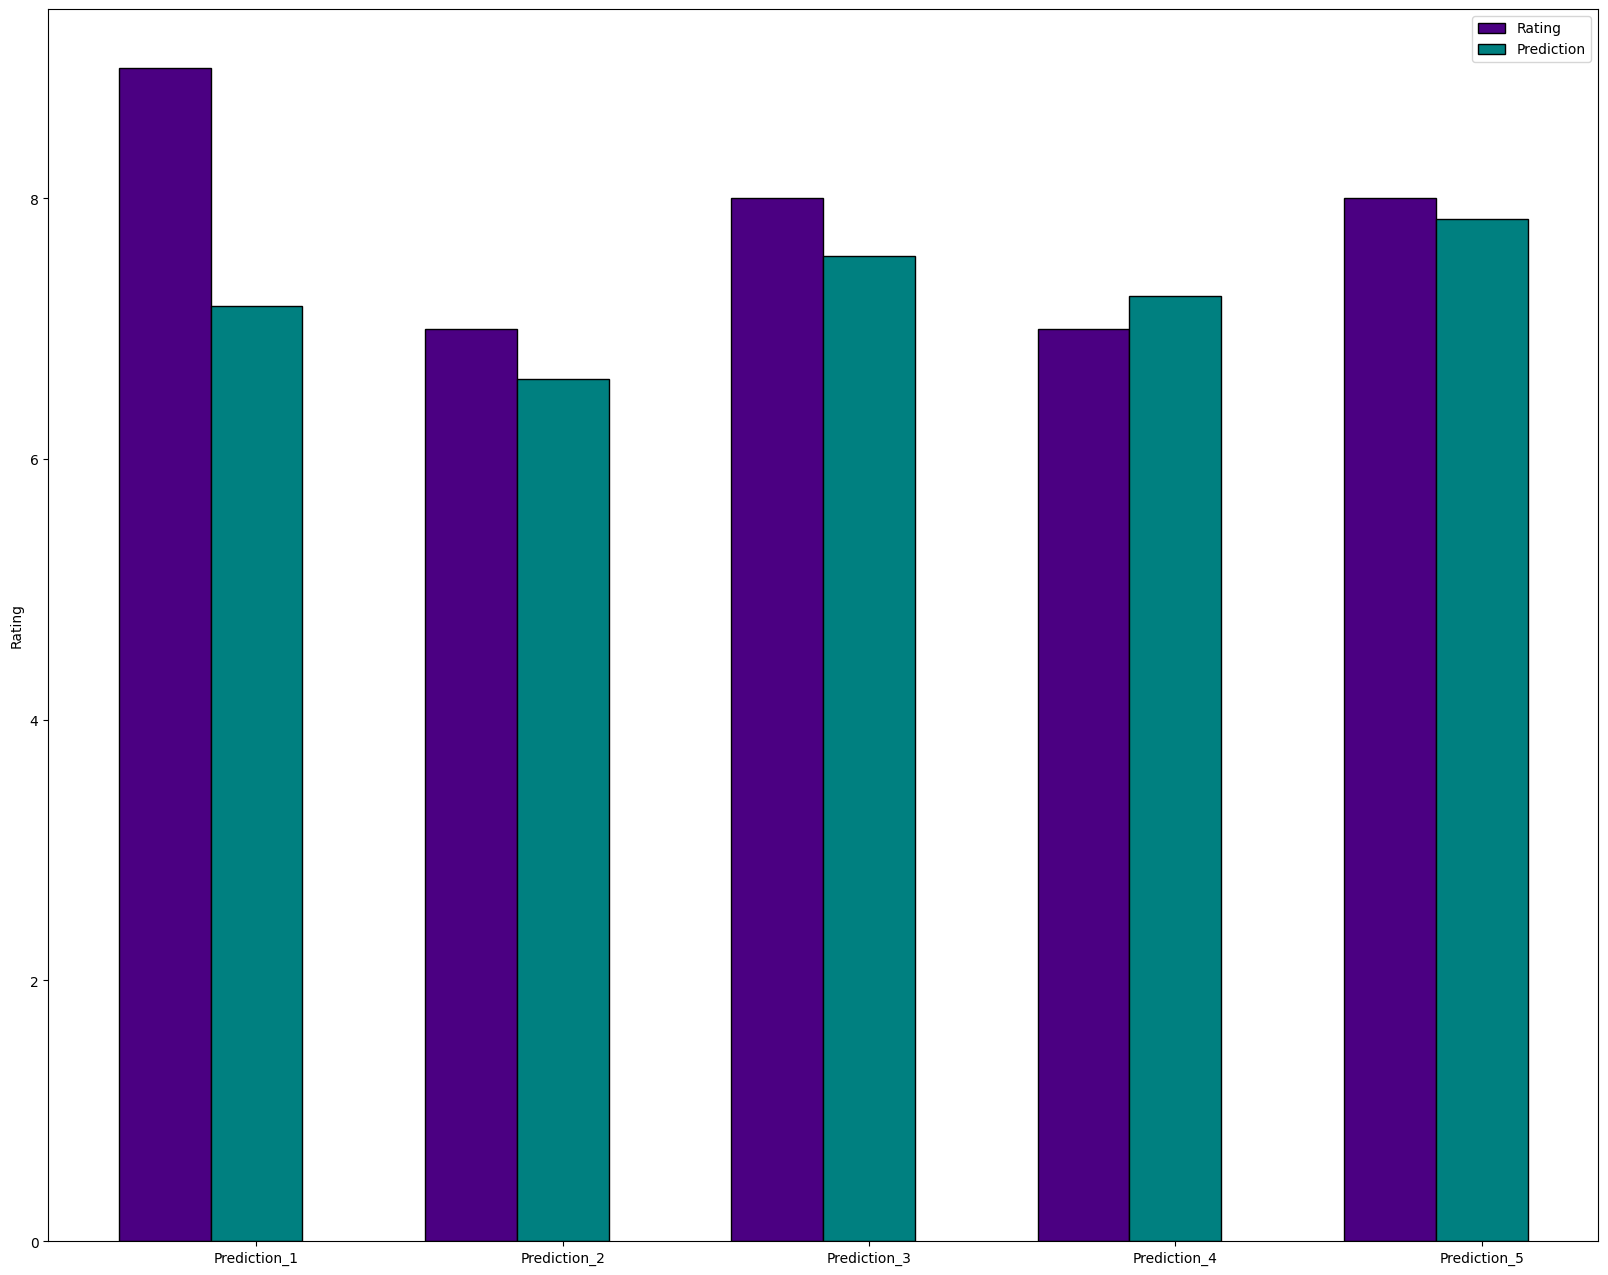

In [ ]:
rank, iter, lambda_ = 50, 15, 0.1
model = ALS.train(trainingData, rank=rank, iterations=iter, lambda_=lambda_, seed=2506)

predictions = model.predictAll(testData)
allPredictRatings=predictions.map(lambda l: float(l[2]))
arr_allPredictRatings=allPredictRatings.collect()

allTestRatings = testRatings.map(lambda l: l.split(',')).map(lambda l: (float(l[2])))
arr_allTestRatings=allTestRatings.collect()

calc_mse(arr_allTestRatings, arr_allPredictRatings)
plot_performance_evaluation_of_model(arr_allTestRatings, arr_allPredictRatings)

The Mean Square Error is:  5.786300401418844


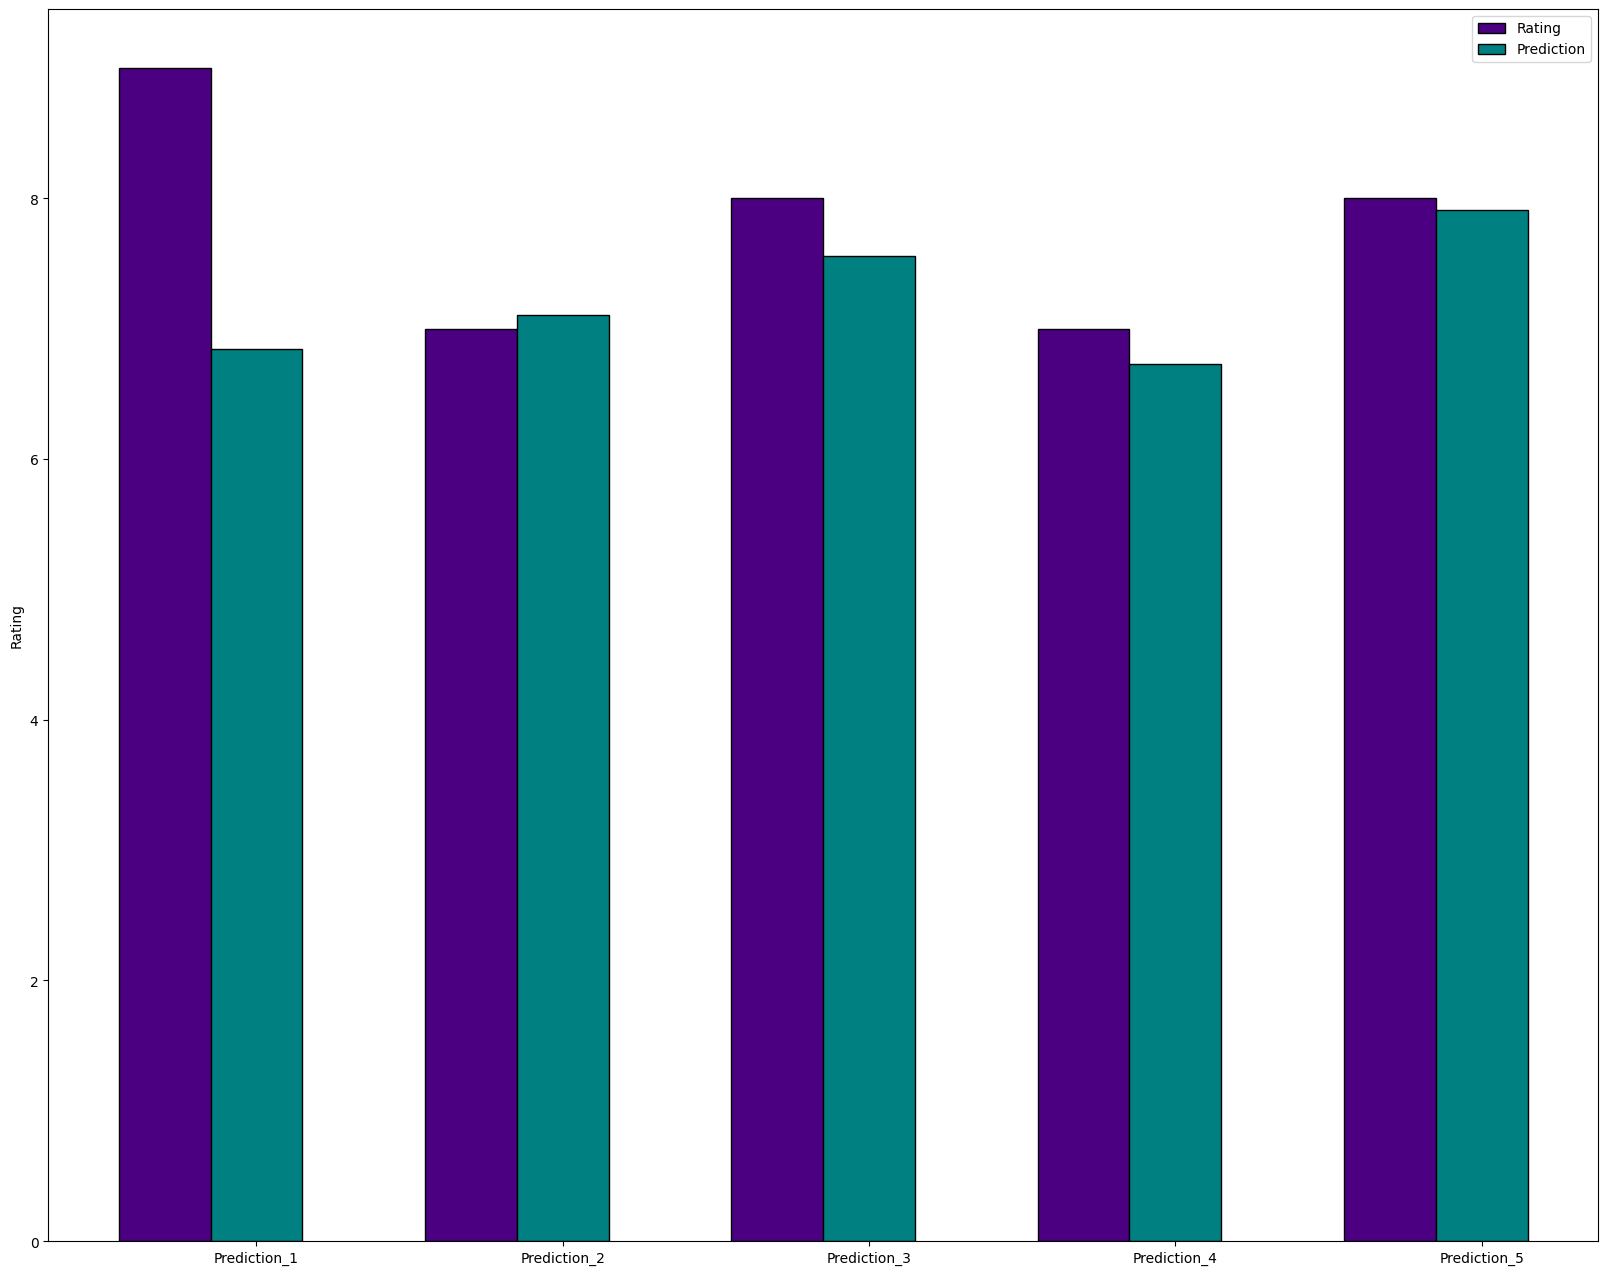

In [ ]:
rank, iter, lambda_ = 50, 10, 0.01
model = ALS.train(trainingData, rank=rank, iterations=iter, lambda_=lambda_, seed=2506)
predictions = model.predictAll(testData)
allPredictRatings=predictions.map(lambda l: float(l[2]))
arr_allPredictRatings=allPredictRatings.collect()
allTestRatings = testRatings.map(lambda l: l.split(',')).map(lambda l: (float(l[2])))
arr_allTestRatings=allTestRatings.collect()
calc_mse(arr_allTestRatings, arr_allPredictRatings)
plot_performance_evaluation_of_model(arr_allTestRatings, arr_allPredictRatings)

In [ ]:
rank, iter, lambda_ = 200, 10, 0.01
model = ALS.train(trainingData, rank=rank, iterations=iter, lambda_=lambda_, seed=2506)

predictions = model.predictAll(testData)
allPredictRatings=predictions.map(lambda l: float(l[2]))
arr_allPredictRatings=allPredictRatings.collect()

allTestRatings = testRatings.map(lambda l: l.split(',')).map(lambda l: (float(l[2])))
arr_allTestRatings=allTestRatings.collect()
calc_mse(arr_allTestRatings, arr_allPredictRatings)
plot_performance_evaluation_of_model(arr_allTestRatings, arr_allPredictRatings)


We select the Best trained model

In [ ]:
rating = sc.textFile("/content/drive/MyDrive/animeandchill/preprocessed_data/rating.csv")
header = rating.first() #extract header
rating = rating.filter(lambda row: row != header)   #filter out header
rating.take(3)

['2485327,59,6', '2485327,74,7', '2485327,120,8']

In [ ]:
rating = rating.map(lambda l: l.split(',')).map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))
rating.take(3)

[Rating(user=2485327, product=59, rating=6.0),
 Rating(user=2485327, product=74, rating=7.0),
 Rating(user=2485327, product=120, rating=8.0)]

In [ ]:
rank, iter, lambda_ = 50, 10, 0.1
model_final = ALS.train(rating, rank=rank, iterations=iter, lambda_=lambda_, seed=2506)



1.  Model Training: We train the ALS model using user ratings data. The model parameters include rank, number of iterations, regularization parameter (lambda), and a seed for reproducibility.
2.  Feature Extraction: After training, we extract and count the latent features learned by the model for both users (userFeatures()) and products (productFeatures()). These features represent the underlying preferences and characteristics derived from the interaction data.
3. Model Evaluation: We use the trained model to predict ratings on a test dataset and then calculate the Mean Squared Error (MSE) to assess prediction accuracy. Additionally, we visually compare actual and predicted ratings for a subset of users to provide intuitive insights into model performance.

In [ ]:
model_final.userFeatures().count()

1128

In [ ]:
model_final.productFeatures().count()

6562

### Predicted Rating

In [ ]:
predicted_rating = model_final.predict(2485327, 59)
predicted_rating

6.314044091330474

----------Matrix Factorization --------------

In [ ]:
!pip install matrix-factorization

  Preparing metadata (setup.py) ... done
  Created wheel for matrix-factorization: filename=matrix_factorization-1.3-py3-none-any.whl size=16447 sha256=edaf5032a2d556d08cf9eb27b6610b53021c7fc7028caee53333192b00018198
  Stored in directory: /root/.cache/pip/wheels/20/55/7a/7f55628acaf4bc0adbb5199e744d098a483e01df9adf290f2f
Successfully built matrix-factorization


In [ ]:
from pyspark.mllib.recommendation import MatrixFactorizationModel

model_final.save(sc, "/content/drive/MyDrive/Cloud_Computing/model1")
# Load Model
sameModel = MatrixFactorizationModel.load(sc, "/content/drive/MyDrive/Cloud_Computing/model1")

Recommend the K number of animes for same user

In [ ]:
userId= 2485327
K=10
top_k_recs = sameModel.recommendProducts(userId,K)
for i in top_k_recs:
    print(i)

Rating(user=2485327, product=5114, rating=8.6200736151617)
Rating(user=2485327, product=28977, rating=8.596798882442387)
Rating(user=2485327, product=9969, rating=8.469460207410439)
Rating(user=2485327, product=15335, rating=8.368420685898649)
Rating(user=2485327, product=11061, rating=8.339448987105657)
Rating(user=2485327, product=34096, rating=8.296591137648267)
Rating(user=2485327, product=918, rating=8.290589292586137)
Rating(user=2485327, product=15417, rating=8.286185919396885)
Rating(user=2485327, product=28851, rating=8.21293888010285)
Rating(user=2485327, product=2904, rating=8.207045940635304)


## Loading and Cleaning Data
* Data Import: Importing the anime dataset from a CSV file into a Spark DataFrame, specifying that the first row contains header information.

* Data Cleaning: We apply a dropna() method to remove any rows with missing values, ensuring the integrity of our dataset for subsequent analysis.

* Conversion to RDD: To get more flexible data manipulations, the DataFrame is converted into an RDD.

In [ ]:
animes = spark.read.csv("/content/drive/MyDrive/animeandchill/preprocessed_data/anime.csv", header=True)
animes = animes.dropna()
animes = animes.rdd

In [ ]:
anime_titles = animes.map(lambda line: line[:2]) \
                     .map(lambda x: (int(float(x[0])), x[1])).collectAsMap()

In [ ]:
for index, (anime_id, title) in enumerate(anime_titles.items()):
    print(anime_id, title)
    if index == 9:  # This stops the loop after printing 10 items
        break

11013 Inu x Boku SS
2104 Seto no Hanayome
5262 Shugo Chara!! Doki
721 Princess Tutu
12365 Bakuman. 3rd Season
6586 Yume-iro Pâtissière
178 Ultra Maniac
2787 Shakugan no Shana II (Second)
4477 Nodame Cantabile: Paris-hen
853 Ouran Koukou Host Club


In [ ]:
rating = rating.map(lambda x: Rating(int(x[0]), int(x[1]), float(x[2])))

In [ ]:
animes_for_user = rating.keyBy(lambda x: x.user)
animes_for_user.take(10)

[(2485327, Rating(user=2485327, product=59, rating=6.0)),
 (2485327, Rating(user=2485327, product=74, rating=7.0)),
 (2485327, Rating(user=2485327, product=120, rating=8.0)),
 (2485327, Rating(user=2485327, product=178, rating=5.0)),
 (2485327, Rating(user=2485327, product=210, rating=7.0)),
 (2485327, Rating(user=2485327, product=232, rating=9.0)),
 (2485327, Rating(user=2485327, product=249, rating=7.0)),
 (2485327, Rating(user=2485327, product=269, rating=8.0)),
 (2485327, Rating(user=2485327, product=853, rating=9.0)),
 (2485327, Rating(user=2485327, product=857, rating=7.0))]

In [ ]:
animes_for_user = rating.keyBy(lambda x: x.user).lookup(2485327)

In [ ]:
len(animes_for_user)

3012

In [ ]:
animes_for_user.sort(reverse=True,key= lambda x: x.rating)

In [ ]:
# Anime for the particular user
animes_for_user

[Rating(user=2485327, product=16, rating=10.0),
 Rating(user=2485327, product=392, rating=10.0),
 Rating(user=2485327, product=777, rating=10.0),
 Rating(user=2485327, product=877, rating=10.0),
 Rating(user=2485327, product=918, rating=10.0),
 Rating(user=2485327, product=1535, rating=10.0),
 Rating(user=2485327, product=1575, rating=10.0),
 Rating(user=2485327, product=1604, rating=10.0),
 Rating(user=2485327, product=2904, rating=10.0),
 Rating(user=2485327, product=4081, rating=10.0),
 Rating(user=2485327, product=5114, rating=10.0),
 Rating(user=2485327, product=9969, rating=10.0),
 Rating(user=2485327, product=10087, rating=10.0),
 Rating(user=2485327, product=10408, rating=10.0),
 Rating(user=2485327, product=11061, rating=10.0),
 Rating(user=2485327, product=11741, rating=10.0),
 Rating(user=2485327, product=12531, rating=10.0),
 Rating(user=2485327, product=13601, rating=10.0),
 Rating(user=2485327, product=15335, rating=10.0),
 Rating(user=2485327, product=15417, rating=10.0)

### Displaying Top 10 Recommendations for a Specific User
10 animes with the highest ratings for user 2485327

In [ ]:
sc.parallelize(animes_for_user[:10])\
.map(lambda rating: (anime_titles[rating.product], rating.rating)).collect()

[('Hachimitsu to Clover', 10.0),
 ('Yuu☆Yuu☆Hakusho', 10.0),
 ('Hellsing Ultimate', 10.0),
 ('Nana', 10.0),
 ('Gintama', 10.0),
 ('Death Note', 10.0),
 ('Code Geass: Hangyaku no Lelouch', 10.0),
 ('Katekyo Hitman Reborn!', 10.0),
 ('Code Geass: Hangyaku no Lelouch R2', 10.0),
 ('Natsume Yuujinchou', 10.0)]

Top 10 recommendations for user 2485327

In [ ]:
sc.parallelize(top_k_recs)\
.map(lambda rating: (anime_titles[rating.product], rating.rating))\
.collect()

[('Fullmetal Alchemist: Brotherhood', 8.6200736151617),
 ('Gintama°', 8.596798882442387),
 ('Gintama&#039;', 8.469460207410439),
 ('Gintama Movie 2: Kanketsu-hen - Yorozuya yo Eien Nare', 8.368420685898649),
 ('Hunter x Hunter (2011)', 8.339448987105657),
 ('Gintama.', 8.296591137648267),
 ('Gintama', 8.290589292586137),
 ('Gintama&#039;: Enchousen', 8.286185919396885),
 ('Koe no Katachi', 8.21293888010285),
 ('Code Geass: Hangyaku no Lelouch R2', 8.207045940635304)]

Recommend the top-K users for a given product

In [ ]:
model =  MatrixFactorizationModel.load(sc, "/content/drive/MyDrive/Cloud_Computing/model1")

In [ ]:
productID = 1575
K = 10
topKuser= model.recommendUsers(productID,K)
for i in topKuser:
    print(i)

Rating(user=3717201, product=1575, rating=10.937433975455225)
Rating(user=187070, product=1575, rating=10.73523770649741)
Rating(user=37830, product=1575, rating=10.542427985401828)
Rating(user=3535317, product=1575, rating=10.52166000191333)
Rating(user=5330916, product=1575, rating=10.491076413637272)
Rating(user=2528591, product=1575, rating=10.467571478903345)
Rating(user=321224, product=1575, rating=10.464050107887873)
Rating(user=6493369, product=1575, rating=10.435904560105703)
Rating(user=3458229, product=1575, rating=10.428487729282676)
Rating(user=1396673, product=1575, rating=10.424884422946674)


In [ ]:
user_df = pd.read_csv('/content/drive/MyDrive/animeandchill/preprocessed_data/user.csv',
                      usecols=['username', 'user_id', 'gender', 'location', 'age'])

In [ ]:
rating_df = pd.read_csv('/content/drive/MyDrive/animeandchill/preprocessed_data/rating.csv')

In [ ]:
combined_df = pd.merge(user_df, rating_df, on='user_id')

combined_df.head()

,username,user_id,gender,location,age,anime_id,my_score
0,MistButterfly,2485327,Female,~ Hungary ~,30,59,6
1,MistButterfly,2485327,Female,~ Hungary ~,30,74,7
2,MistButterfly,2485327,Female,~ Hungary ~,30,120,8
3,MistButterfly,2485327,Female,~ Hungary ~,30,178,5
4,MistButterfly,2485327,Female,~ Hungary ~,30,210,7


In [ ]:
users_with_IDs = dict(zip(combined_df.username, combined_df.user_id))

In [ ]:
IDs_with_users = {v: k for k, v in users_with_IDs.items()}

Top 10 users for anime 1575

In [ ]:
sc.parallelize(topKuser)\
.map(lambda rating: (IDs_with_users[rating.user], rating.user))\
.collect()

[('OrangeJP', 3717201),
 ('Blutsauger', 187070),
 ('Bleach2903', 37830),
 ('NoFear94', 3535317),
 ('animangafreak_ZX', 5330916),
 ('Mikura-san', 2528591),
 ('mangafreakZX', 321224),
 ('Z3R0215', 6493369),
 ('serialbruno', 3458229),
 ('Deodatus', 1396673)]

################################################

COSINE SIMILARITY

################################################

Here we use the application of cosine similarity to enhance our anime recommendation system. Cosine similarity measures the cosine of the angle between two vectors in a multi-dimensional space, providing a metric that assesses how similar two items are in terms of user preferences and characteristics.

In [ ]:
def cosineSimilarity(item_id,a,b):
    dot=np.dot(a,b)
    norma = np.linalg.norm(a)
    normb = np.linalg.norm(b)
    cos= dot/ (norma*normb)
    return item_id,cos

In [ ]:
item_id=1565
item_vector= model.productFeatures().lookup(item_id)[0]
item_vector

array('d', [0.2607470154762268, 0.22445732355117798, 0.23532459139823914, -0.44821321964263916, -0.45214417576789856, -0.013075761497020721, -0.3237763047218323, 0.04218002408742905, 0.09337328374385834, -0.20087884366512299, 0.3278241455554962, 0.1450204849243164, -0.11393271386623383, -0.05783959478139877, 0.16383829712867737, -0.73830246925354, -0.04580305889248848, -0.5052189230918884, -0.23235879838466644, 0.1658041924238205, -0.04781496524810791, 0.630386471748352, 0.14573857188224792, -0.564679741859436, -0.395537793636322, -0.5439764261245728, 0.4233396053314209, 0.08868617564439774, 0.22484897077083588, -0.7938290238380432, 0.5568776726722717, 0.05543931946158409, 0.03428379446268082, 0.07818999886512756, 0.04957319423556328, -0.16093336045742035, -0.5794907212257385, 0.577317476272583, 0.08768697082996368, -0.42339569330215454, -0.204875186085701, 0.06927058100700378, 0.2134968489408493, -0.4235735237598419, -0.02400452271103859, 0.14630040526390076, 0.6750403046607971, 0.213

In [ ]:
anime_titles[item_id]

'Pokemon Diamond & Pearl'

In [ ]:
cosineSimilarity(item_id,item_vector,item_vector)

(1565, 1.0)

In [ ]:
sims= model.productFeatures().map(lambda data: cosineSimilarity(data[0],data[1],item_vector))
top_10_animes = sims.top(10,key=lambda x:x[1])
top_10_animes

[(1565, 1.0),
 (1564, 0.9703018873007105),
 (4026, 0.9672962617573981),
 (6178, 0.9662758110321499),
 (2847, 0.9643191904347842),
 (1119, 0.963418204638069),
 (7695, 0.9580852970171719),
 (1709, 0.9572805789941307),
 (2201, 0.9571936212803325),
 (527, 0.9568284225459761)]

In [ ]:
top_10_animes_titles = [anime_titles[a[0]] for a in top_10_animes]
top_10_animes_titles

['Pokemon Diamond & Pearl',
 'Pokemon Advanced Generation',
 'Pokemon Diamond & Pearl: Giratina to Sora no Hanataba Sheimi',
 'Pokemon Diamond & Pearl: Arceus Choukoku no Jikuu e',
 'Pokemon Diamond & Pearl: Dialga vs. Palkia vs. Darkrai',
 'Pokemon: Celebi Toki wo Koeta Deai',
 'Pokemon Diamond & Pearl: Genei no Hasha Zoroark',
 'Pokemon: Mewtwo! Ware wa Koko ni Ari',
 'Pokemon Advanced Generation: Pokemon Ranger to Umi no Ouji Manaphy',
 'Pokemon']